In this notebook we show how we can synthesize dimensionality reduction models across subjects when we record data from different conditions from each of those subjects.  We demonstrate that we can reliably see how the latent variables for each condition are located with respect to one another in a low-d space, even though the data for each condition comes from a different subject.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
from pathlib import Path
import random

from matplotlib import cm
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import ot
import scipy.io
import sklearn.decomposition as decomposition
import sklearn.discriminant_analysis as discriminant_analysis
import torch

from janelia_core.ml.utils import list_torch_devices
from janelia_core.visualization.image_generation import max_project_pts
from janelia_core.visualization.image_generation import generate_dot_image_3d
from janelia_core.visualization.custom_color_maps import make_purple_green_c_map
from janelia_core.visualization.volume_visualization import visualize_projs
from janelia_core.visualization.volume_visualization import signed_max_proj
from janelia_core.math.basic_functions import optimal_orthonormal_transform
from probabilistic_model_synthesis.data_utils import read_in_ahrens_data_for_dim_reduction
from probabilistic_model_synthesis.fa import orthonormalize
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import evaluate_check_points
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import infer_latents
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import PriorCollection
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import synthesize_fa_mdls
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import VICollection


/groups/fitzgerald/fitzgeraldlab/bishoplab/projects/janelia_core/janelia_core/visualization/volume_visualization.py:22: UserWarning: Unable to import moviepy.  Minor functionality will not be available.
  warnings.warn('Unable to import moviepy.  Minor functionality will not be available.')


In [3]:
%matplotlib notebook
plt.style.use("default")

In [4]:
# Set random seeds for perfectly reproducable results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

## Parameters go here

In [5]:
ps = dict()

# Specify the directory where all the raw data is found
ps['data_dir'] = r'/groups/fitzgerald/fitzgeraldlab/bishoplab/projects/probabilistic_model_synthsis/data'

# Here we list the subject we want to fit and the conditions we want to fit on for each subject when we observe data
# from different conditions for different subjects
ps['diff_cond_fit_specs'] = {8: ['omr_forward'], 
                             9: ['omr_left'], 
                            11: ['omr_right']} 

# Here we list the subject we want to fit and the conditions we want to fit on for each subject when we observe data
# for all conditions for each subject - we use this data for fitting baseline FA models to
ps['all_cond_fit_specs'] = {8: ['omr_forward', 'omr_left', 'omr_right'], 
                            9: ['omr_forward', 'omr_left', 'omr_right'], 
                            11: ['omr_forward', 'omr_left', 'omr_right']} 
    
# Options for preprocessing the data
ps['preprocess_opts'] = {'neural_gain': 10, 'z_ratio': 2.5}

# Here we specify if we fit in conditions with shock or not
ps['shock'] = False

# Number of inidividual slices of each type of subperiod we use for validation
ps['n_validation_slices'] = 2

# Number of latent variables in the model
ps['n_latent_vars'] = 10

# Options for setting up priors when synthesizing models
ps['prior_opts'] = {'hc_params': {'n_divisions_per_dim': [140, 50, 20], 
                                  'dim_ranges': np.asarray([[0, 1407], 
                                                            [0, 622], 
                                                            [0, np.ceil(137*ps['preprocess_opts']['z_ratio'])]]),
                                  'n_div_per_hc_side_per_dim': [1, 1, 1]},
                    'min_gaussian_std': 1E-6,
                    'min_gamma_conc_vl': 1.0,
                    'max_gamma_conc_vl': 1E3, 
                    'min_gamma_rate_vl': .1,
                    'max_gamma_rate_vl': 1E4,
                    'lm_mn_init': 0.0,
                    'lm_std_init': .01,
                    'mn_mn_init': 0.0,
                    'mn_std_init': .01,
                    'psi_conc_vl_init': 10.0,
                    'psi_rate_vl_init': 10.0,
                    'learnable_stds': True
                   }

# Options for setting up the posteriors when synthesizing models
ps['post_opts'] = {'lm_opts': {'mn_mn': 1.0, 
                               'mn_std': 1E-8,
                               'std_lb': 1E-6,
                               'std_ub': 10.0, 
                               'std_iv': 1E-4},
                   'mn_opts': {'mn_mn': 1.0, 
                               'mn_std': 1E-8,
                               'std_lb': 1E-6,
                               'std_ub': 10.0, 
                               'std_iv': 1E-4},
                   'psi_opts': {'alpha_lb': 1.0,
                                'alpha_ub': 1E3,
                                'alpha_iv': 10.0, 
                                'beta_lb': .1,
                                'beta_ub': 1E4,
                                'beta_iv': 10.0}
                  } 

# Provide a folder to save check points into
ps['cp_save_folder'] = r'/groups/fitzgerald/fitzgeraldlab/bishoplab/projects/probabilistic_model_synthsis/results/publication_results/gnldr/latent_exam/cp'

# Fitting options
ps['sp_fit_opts'] = [{'n_epochs': 1000, 'milestones': [10000], 'update_int': 100, 'init_lr': .01}]
ps['ip_fit_opts'] = [{'n_epochs': 2000, 'milestones': [500], 'update_int': 100, 'init_lr': .01, 
                      'cp_save_folder': ps['cp_save_folder'], 
                      'cp_epochs': list(range(0, 2000, 100)) + [1999]}]

# Location to anatomical stack
ps['anat_file'] = r'/groups/fitzgerald/fitzgeraldlab/bishoplab/projects/probabilistic_model_synthsis/data/ReferenceBrain.mat'

# Percentile at which values saturate when generating mode images.  Between 0 and 100
ps['mode_c_lim_percentile'] = 99

# Location where plot should be saved
ps['save_folder'] = r'/groups/fitzgerald/fitzgeraldlab/bishoplab/projects/probabilistic_model_synthsis/results/publication_results/gnldr/latent_exam/imgs'


## Load the data 

In [6]:
subjects = list(ps['diff_cond_fit_specs'].keys())
subjects.sort()

In [7]:
# Read in data when we observe data from different conditions for different individuals - here we set aside some
# data for validation data, that we will use for early stopping
diff_cond_data, diff_cond_label_map, neuron_locs = read_in_ahrens_data_for_dim_reduction(data_dir = ps['data_dir'], 
                                                                            fit_specs=ps['diff_cond_fit_specs'],
                                                                            shock=ps['shock'], 
                                                                            n_validation_slices=ps['n_validation_slices'],
                                                                            preprocess_opts=ps['preprocess_opts'])

# Read in data when we observe data for all conditions for each individual - we don't need validation data
# here since we just fit these models with standard FA models 
all_cond_data, all_cond_label_map, _ = read_in_ahrens_data_for_dim_reduction(data_dir = ps['data_dir'], 
                                                                            fit_specs=ps['all_cond_fit_specs'],
                                                                            shock=ps['shock'], 
                                                                            n_validation_slices=0,
                                                                            preprocess_opts=ps['preprocess_opts'])

Done loading data for subject subject_8.
Done loading data for subject subject_9.
Done loading data for subject subject_11.
Done loading data for subject subject_8.
Done loading data for subject subject_9.
Done loading data for subject subject_11.


In [8]:
full_diff_cond_data = {s_n: np.concatenate([diff_cond_data['fit_data'][s_n], 
                                       diff_cond_data['validation_data'][s_n]], axis=0)
                  for s_n in subjects}

full_diff_cond_labels = {s_n: np.concatenate([diff_cond_data['fit_labels'][s_n], 
                                         diff_cond_data['validation_labels'][s_n]], axis=0)
                    for s_n in subjects}

## Fit FA models individually to each subject when we observe the same conditions across all subjects and infer latents

Here we fit the models

In [9]:
all_cond_fa_mdls = {}
for s_n in subjects:
    fa_mdl = decomposition.FactorAnalysis(n_components=ps['n_latent_vars'])
    fa_mdl.fit(all_cond_data['fit_data'][s_n])
    all_cond_fa_mdls[s_n] = fa_mdl
    print('Done fitting FA model to subject ' + str(s_n) + ' individually using all conditions.')

Done fitting FA model to subject 8 individually using all conditions.
Done fitting FA model to subject 9 individually using all conditions.
Done fitting FA model to subject 11 individually using all conditions.


Now we infer latents and orthonormalize each model

In [10]:
all_cond_latents = dict()
for s_n in subjects:
    mdl_n = all_cond_fa_mdls[s_n]
    latents = mdl_n.transform(all_cond_data['fit_data'][s_n])
    lm_o, latents_o = orthonormalize(mdl_n.components_.transpose(), latents)
    
    all_cond_latents[s_n] = {'latents': latents, 'latents_o': latents_o, 'lm_o': lm_o, 
                             'lm': mdl_n.components_.transpose()}

## Now we fit standard FA models when we observe fish under different conditions

In [11]:
diff_cond_fa_mdls = {}
for s_n in subjects:
    fa_mdl = decomposition.FactorAnalysis(n_components=ps['n_latent_vars'])
    fa_mdl.fit(full_diff_cond_data[s_n])
    diff_cond_fa_mdls[s_n] = fa_mdl
    print('Done fitting FA model to subject ' + str(s_n) + ' individually.')

Done fitting FA model to subject 8 individually.
Done fitting FA model to subject 9 individually.
Done fitting FA model to subject 11 individually.


Here we infer latents and orthonormalize the loading matrices of the models

In [12]:
diff_cond_latents = dict()
for s_n in subjects:
    mdl_n = diff_cond_fa_mdls[s_n]
    latents = mdl_n.transform(full_diff_cond_data[s_n])
    lm_o, latents_o = orthonormalize(mdl_n.components_.transpose(), latents)
    
    diff_cond_latents[s_n] = {'latents': latents, 'latents_o': latents_o, 'lm_o': lm_o, 
                              'lm': mdl_n.components_.transpose()}

And here we align the latents with optimal transport

In [13]:
align_tgt_subject = subjects[0]
align_tgt_latents = diff_cond_latents[align_tgt_subject]['latents_o']
diff_cond_latents[align_tgt_subject]['latents_ot'] = align_tgt_latents
for s_n in subjects[1:]:
    a_ot, b_ot = ot.da.OT_mapping_linear(diff_cond_latents[s_n]['latents_o'], align_tgt_latents)
    diff_cond_latents[s_n]['latents_ot'] = diff_cond_latents[s_n]['latents_o'].dot(a_ot) + b_ot

## Synthesize FA models when we observe data from a different condition in each subject

Here we fit the models

In [14]:
syn_rs = synthesize_fa_mdls(data=[torch.tensor(diff_cond_data['fit_data'][s_n]) for s_n in subjects],
                   props=[neuron_locs[s_n] for s_n in subjects], 
                   n_latent_vars=ps['n_latent_vars'],
                   prior_opts=ps['prior_opts'], 
                   post_opts=ps['post_opts'], 
                   sp_fit_opts=ps['sp_fit_opts'], 
                   ip_fit_opts=ps['ip_fit_opts'],
                   sp_fixed_var=True)

Found 1 GPUs
Fixing standard deviation of sp loading matrix and mean priors.

=========== EPOCH 0 COMPLETE ===========
Obj: 1.80e+08
----------------------------------------
NELL: 1.16e+08, 2.82e+07, 3.56e+07
Latent KL: 1.73e+00, 5.07e-01, 5.10e-01
LM KL: 0.00e+00, 0.00e+00, 0.00e+00
Mn KL: 0.00e+00, 0.00e+00, 0.00e+00
Psi KL: 2.49e+02, 2.86e+02, 3.65e+02
----------------------------------------
LR: 0.01
Elapsed time (secs): 0.8847801685333252
----------------------------------------
CPU cur memory used (GB): 3.84e+00
GPU_0 cur memory used (GB): 2.48e-01, max memory used (GB): 2.48e-01

=========== EPOCH 100 COMPLETE ===========
Obj: 9.60e+07
----------------------------------------
NELL: 5.90e+07, 1.64e+07, 2.05e+07
Latent KL: 5.82e+03, 1.49e+03, 1.54e+03
LM KL: 0.00e+00, 0.00e+00, 0.00e+00
Mn KL: 0.00e+00, 0.00e+00, 0.00e+00
Psi KL: 3.45e+04, 3.73e+04, 3.93e+04
----------------------------------------
LR: 0.01
Elapsed time (secs): 19.646817445755005
----------------------------------

Saved check point for epoch 500.

=========== EPOCH 600 COMPLETE ===========
Obj: 5.42e+07
----------------------------------------
NELL: 3.54e+07, 8.02e+06, 8.49e+06
Latent KL: 2.03e+04, 5.09e+03, 4.99e+03
LM KL: 5.53e+05, 3.44e+05, 4.91e+05
Mn KL: 1.67e+05, 1.89e+05, 2.50e+05
Psi KL: 7.98e+04, 7.38e+04, 9.31e+04
----------------------------------------
LR: 0.001
Elapsed time (secs): 100.95171475410461
----------------------------------------
CPU cur memory used (GB): 4.19e+00
GPU_0 cur memory used (GB): 3.67e-01, max memory used (GB): 3.67e-01
Saved check point for epoch 600.

=========== EPOCH 700 COMPLETE ===========
Obj: 5.42e+07
----------------------------------------
NELL: 3.54e+07, 7.99e+06, 8.44e+06
Latent KL: 2.03e+04, 5.15e+03, 5.07e+03
LM KL: 5.53e+05, 3.45e+05, 4.95e+05
Mn KL: 1.68e+05, 1.90e+05, 2.51e+05
Psi KL: 8.03e+04, 7.39e+04, 9.35e+04
----------------------------------------
LR: 0.001
Elapsed time (secs): 117.9248526096344
----------------------------------------
C

Here we perform (retrospective) early stopping using validation data

In [15]:
devices, _ = list_torch_devices()

Found 1 GPUs


In [16]:
cp_epochs, cp_elbo, cp_files, cp_logs = evaluate_check_points(cp_folder=ps['cp_save_folder'], 
                              data=[torch.tensor(diff_cond_data['validation_data'][s_n]) for s_n in subjects], 
                              props=[neuron_locs[s_n] for s_n in subjects], 
                              n_smps=100, device=devices[0])

Done with check point: 1 of 21.
Done with check point: 2 of 21.
Done with check point: 3 of 21.
Done with check point: 4 of 21.
Done with check point: 5 of 21.
Done with check point: 6 of 21.
Done with check point: 7 of 21.
Done with check point: 8 of 21.
Done with check point: 9 of 21.
Done with check point: 10 of 21.
Done with check point: 11 of 21.
Done with check point: 12 of 21.
Done with check point: 13 of 21.
Done with check point: 14 of 21.
Done with check point: 15 of 21.
Done with check point: 16 of 21.
Done with check point: 17 of 21.
Done with check point: 18 of 21.
Done with check point: 19 of 21.
Done with check point: 20 of 21.
Done with check point: 21 of 21.


Plot validation performance with check points 

<IPython.core.display.Javascript object>


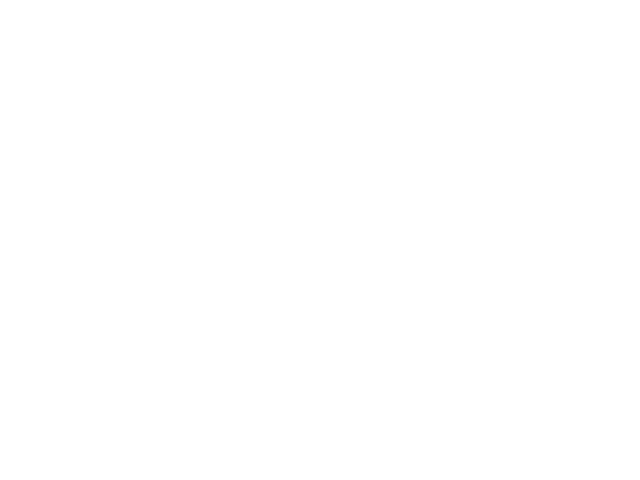

In [17]:
if len(cp_epochs) > 0:
    plt.figure()
    plt.plot(cp_epochs, np.mean(cp_elbo, axis=1))
    plt.xlabel('Check point Epoch')
    plt.ylabel('Mean ELBO')

In [18]:
if len(cp_epochs) > 0:
    best_cp_epoch = cp_epochs[np.argmax(np.mean(cp_elbo, axis=1))].astype('int')
    print('Best epoch is ' + str(best_cp_epoch) + '.')

    best_cp = torch.load(Path(ps['cp_save_folder']) / ('cp_' + str(best_cp_epoch) + '.pt'))    
    eval_vi_collections = [VICollection.from_checkpoint(coll_d) for coll_d in best_cp['vi_collections']]
    for c_i, coll in enumerate(eval_vi_collections):
        coll.props = syn_rs['ip']['vi_collections'][c_i].props
    eval_priors = PriorCollection.from_checkpoint(best_cp['priors'])
    eval_posteriors = [coll.posteriors for coll in eval_vi_collections]  
else:
    pass

Best epoch is 100.


Here we infer latents using the best model (picked with early stopping) using all data and orthonormalize each model

In [19]:
full_syn_data = {s_n: np.concatenate([diff_cond_data['fit_data'][s_n], 
                                       diff_cond_data['validation_data'][s_n]], axis=0)
                  for s_n in subjects}

full_syn_labels = {s_n: np.concatenate([diff_cond_data['fit_labels'][s_n], 
                                         diff_cond_data['validation_labels'][s_n]], axis=0)
                    for s_n in subjects}

In [20]:
syn_latent_posts ={s_n: infer_latents(n_latent_vars=ps['n_latent_vars'],
                                      vi_collection=eval_vi_collections[s_i],
                                      data=torch.tensor(full_syn_data[s_n]),
                                      fit_opts={'n_epochs': 1000, 'init_lr':.1, 'update_int':None, 
                                                'milestones': [500]}, 
                                      device=devices[0])[0]
                    for s_i, s_n in enumerate(subjects)}

In [21]:
# We orthonormalize based on the a loading matrix formed for neurons across all fish
syn_lm_conc = torch.cat([eval_posteriors[s_i].lm_post(neuron_locs[s_n]) for s_i, s_n in enumerate(subjects)],
                         dim=0).detach().numpy()

syn_latents = dict()
for s_n in subjects:
    latents = syn_latent_posts[s_n].mns.detach().numpy()
    _, latents_o = orthonormalize(syn_lm_conc, latents)
    syn_latents[s_n] = {'latents': latents, 'latents_o': latents_o}

## Get things in place for plotting

In [22]:
n_subperiods = len(all_cond_label_map)
subperiod_clrs = {'omr_right': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0), # Red
                  'omr_left': (1.0, 0.4980392156862745, 0.0, 1.0), # Orange 
                  'omr_forward': (0.6, 0.6, 0.6, 1.0)} # Gray 
subject_markers = {8: '.', 9: 'd', 11:'2'}

In [23]:
def plot_latents(subj_data: dict, label_map, sp_clrs, subj_markers, subj_specific_axes = True,  
                 x_label:str = 'Latent Dim 1 (a.u.)', y_label:str = 'Latent Dim 2 (a.u.)', 
                 z_label:str = 'Latent Dim 3 (a.u.)', markersize=10):
    """ Plot latent points for different subjects. 
    
    Args:
        subj_pts: Keys correspond to subject numbers.  
    """
    
    plt_subjs = list(subj_data.keys())
    plt_subjs.sort()
    n_subjs = len(plt_subjs)
    n_dim = subj_data[plt_subjs[0]]['pts'].shape[1]
    
    n_rows = int(np.ceil(np.sqrt(n_subjs)))
    n_cols = int(np.ceil(n_subjs/n_rows))
    
    plt.figure()
    
    if not subj_specific_axes:
        if n_dim > 2:
            ax = plt.subplot(1, 1, 1, projection='3d')
        else:
            ax = plt.subplot(1, 1, 1)
    
    for s_i, s_n in enumerate(plt_subjs):
        if subj_specific_axes:
            if n_dim > 2: 
                ax = plt.subplot(n_rows, n_cols, s_i+1, projection='3d')
            else:
                ax = plt.subplot(n_rows, n_cols, s_i+1)
                
            plt.title('Subject ' + str(s_n))
        
        plot_pts = subj_data[s_n]['pts']
        plot_labels = subj_data[s_n]['labels']
        plot_vec_pts = subj_data[s_n]['plot_vec_pts']
        
        for sp, sp_lbl in label_map.items():
            sp_clr = sp_clrs[sp]
            sp_inds = plot_labels == sp_lbl
            if n_dim > 2:
                ax.plot(plot_pts[sp_inds,0], plot_pts[sp_inds,1], plot_pts[sp_inds,2], 
                        markeredgecolor=sp_clr, marker=subj_markers[s_n], markersize=markersize, 
                        linestyle='', markerfacecolor=(0,0,0,0))
            else:
                ax.plot(plot_pts[sp_inds,0], plot_pts[sp_inds,1], markeredgecolor=sp_clr, marker=subj_markers[s_n], 
                           markersize=markersize, linestyle='', markerfacecolor=(0,0,0,0))
                
        if plot_vec_pts is not None:
            ax.plot(plot_vec_pts[:,0], plot_vec_pts[:,1], 'k--')
        
        ax.set_aspect('equal')
        
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        if n_dim > 3:
            ax.set_zlabel(z_label)
                 
    plt.subplots_adjust(wspace=.3, hspace=.4)
    

In [24]:
def vis_mode(rb_horz, rb_sag, rb_cor, vol, cmap, clims):
    f = plt.figure(figsize=[4,8])
    visualize_projs(horz_projs=[rb_horz, signed_max_proj(vol,2)],
                    sag_projs=[rb_sag, signed_max_proj(vol,1)], 
                    cor_projs=[rb_cor, np.fliplr(signed_max_proj(vol,0))], 
                    cmaps=[cm.gray, cmap], 
                    clims=[[0, 1], clims], 
                    plot_cmap=True, 
                    buffer=.1, 
                    dim_m=[1,1,2.5], 
                    f=f)

In [25]:
def find_best_rot(pts_0, labels_0, pts_1, labels_1):

    matched_pts_1 = np.zeros(pts_0.shape)
    
    for pt_i, label in enumerate(labels_0):
        match_inds = np.argwhere(labels_1 == label).squeeze()
        rand_ind = random.choice(match_inds)
        matched_pts_1[pt_i,:] = pts_1[rand_ind, :]
        
    return optimal_orthonormal_transform(pts_0, matched_pts_1)
    

In [26]:
def get_diff_dir(cond_1_latents, cond_2_latents, lm):

    dir_pts = np.stack([np.mean(cond_1_latents, axis=0), np.mean(cond_2_latents, axis=0)], axis=1).transpose()
    
    dir_vec = dir_pts[1,:] - dir_pts[0,:]
    dir_vec = np.expand_dims(dir_vec, -1)
    
    return (np.matmul(lm, dir_vec), dir_pts)
    

In [27]:
def get_lda_projs(latents: dict, labels: dict, c0: str, c1: str, label_map: dict, ex_lm: np.ndarray,
                  tgt_pts: np.ndarray = None, tgt_labels: np.ndarray = None):
    
    all_latents = np.concatenate([latents[s_n] for s_n in latents.keys()], axis=0)
    all_labels = np.concatenate([labels[s_n] for s_n in labels.keys()], axis=0)
    n_latent_dims = all_latents.shape[1]
    
    # Get LDA projection best seperating all three clases
    lda_mdl = discriminant_analysis.LinearDiscriminantAnalysis()
    lda_mdl.fit(all_latents, all_labels)
    
    # Get the low and high-d projections seperating the mean of two of the conditions
    diff_dirs = get_diff_dir(all_latents[all_labels == label_map[c0], :], 
                            all_latents[all_labels == label_map[c1], :], 
                            ex_lm)
    
    # Get rotation best aligning points in the LDA space for all three classes to a given set of points
    if tgt_pts is not None:
        rot = find_best_rot(tgt_pts, tgt_labels, 
                            lda_mdl.transform(all_latents), all_labels)
    else:
        rot = np.eye(2)
                            
    # Transform the latents into the space best seperating all three classes
    lda_pts = {s_n: {'pts': np.matmul(lda_mdl.transform(latents[s_n]), rot),
                     'labels': labels[s_n]}
                     for s_n in latents.keys()}
    
    # Transform vector between means into the space best seperating all three classes 
    diff_dir_pts = np.matmul(lda_mdl.transform(diff_dirs[1]), rot)
                                              
    # Return results
    return {'lda_pts': lda_pts, 'disc_vec_pts': diff_dir_pts, 'disc_vec_high_d': diff_dirs[0]}

In [28]:
def joint_orth(lms: list):

    lm_conc = np.concatenate(lms, axis=0)
    u, s, v = np.linalg.svd(lm_conc, full_matrices=False)
    
    print('Percent variance explained by each latent dimension: ' + str(100*(s**2)/(np.sum(s**2))))
    
    return [np.matmul(lm, v.transpose())/s for lm in lms]

## View LDA projection of data when we observe all conditions in all subjects. 

This is to provide a baseline to see how the low-d projections of data look when we have the ability to record data
for all subjects in each subject

In [29]:
ex_vis_s_n = 8 # The example subject that we show latents for when we observe all conditions in one fish.  This will
               # also be the fish we use the loading matrix for when projecting latents into neural space

In [30]:
cmp_conds = ['omr_left', 'omr_right'] # The two conditions we look for the most discriminable direction for

In [31]:
all_cond_lda_rs = dict()

all_cond_lda_rs[ex_vis_s_n] = get_lda_projs(latents={ex_vis_s_n: all_cond_latents[ex_vis_s_n]['latents']},
                                      labels={ex_vis_s_n: all_cond_data['fit_labels'][ex_vis_s_n]},
                                      c0=cmp_conds[0], c1=cmp_conds[1], 
                                      label_map=all_cond_label_map, 
                                      ex_lm=all_cond_latents[ex_vis_s_n]['lm'])

for s_n in subjects:
    if s_n != ex_vis_s_n:
        all_cond_lda_rs[s_n] =  get_lda_projs(latents={s_n: all_cond_latents[s_n]['latents']},
                                                       labels={s_n: all_cond_data['fit_labels'][s_n]},
                                                       c0=cmp_conds[0], c1=cmp_conds[1], 
                                                       label_map=all_cond_label_map, 
                                                       ex_lm=all_cond_latents[s_n]['lm'], 
                                                       tgt_pts=all_cond_lda_rs[ex_vis_s_n]['lda_pts'][ex_vis_s_n]['pts'] , 
                                                       tgt_labels=all_cond_data['fit_labels'][ex_vis_s_n])

<IPython.core.display.Javascript object>


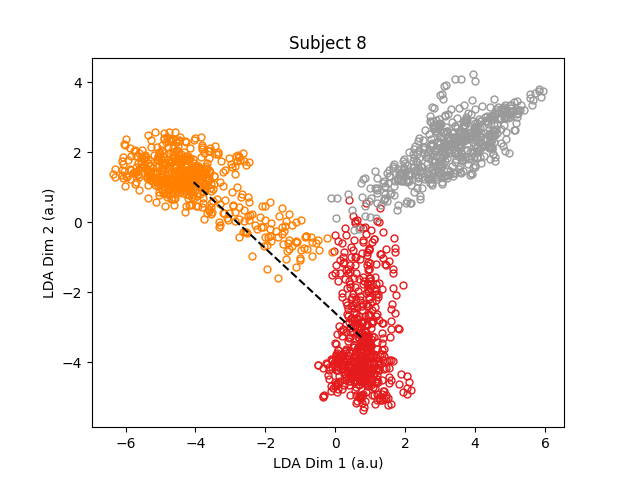

<IPython.core.display.Javascript object>


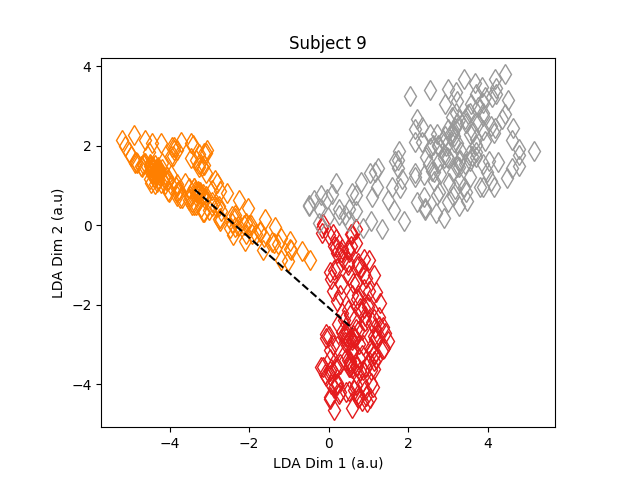

<IPython.core.display.Javascript object>


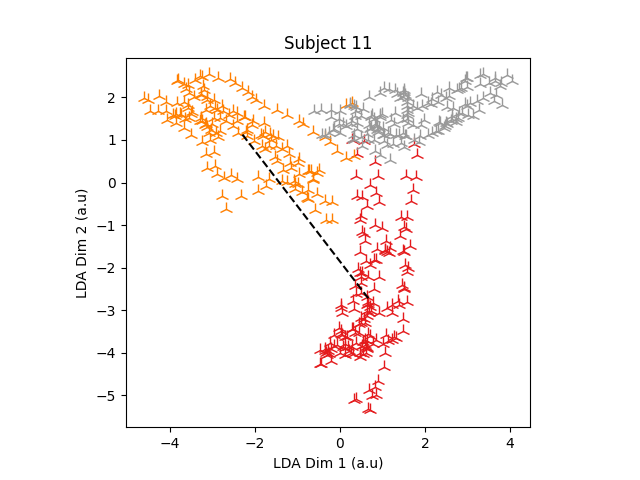

In [78]:
for s_n in subjects:  
    plot_dict = {'pts': all_cond_lda_rs[s_n]['lda_pts'][s_n]['pts'], 
                 'labels': all_cond_lda_rs[s_n]['lda_pts'][s_n]['labels'],
                 'plot_vec_pts': all_cond_lda_rs[s_n]['disc_vec_pts']}
    
    plot_latents(subj_data={s_n: plot_dict}, 
                 label_map=all_cond_label_map, 
                 sp_clrs=subperiod_clrs, 
                 subj_markers=subject_markers, 
                 x_label='LDA Dim 1 (a.u)', y_label='LDA Dim 2 (a.u)')
    plt.savefig(Path(ps['save_folder']) / ('standard_fa_all_conds_lda_latents_subj' + str(s_n) + '.eps'), format='eps')

## View low-d projection of data when we observe different conditions in each subject and synthesize models

In [33]:
ex_vis_s_i = np.argwhere(np.asarray(subjects) == ex_vis_s_n)[0][0]
with torch.no_grad():
    syn_ex_vis_s_lm = eval_vi_collections[ex_vis_s_i].posteriors.lm_post(neuron_locs[ex_vis_s_n]).numpy()

In [34]:
syn_lda_rs = get_lda_projs(latents={s_n: syn_latents[s_n]['latents'] for s_n in subjects},
                                 labels={s_n: full_syn_labels[s_n] for s_n in subjects},
                                 c0=cmp_conds[0], c1=cmp_conds[1], 
                                 label_map=diff_cond_label_map, 
                                 ex_lm=syn_ex_vis_s_lm,
                                 tgt_pts=all_cond_lda_rs[ex_vis_s_n]['lda_pts'][ex_vis_s_n]['pts'] , 
                                 tgt_labels=all_cond_data['fit_labels'][ex_vis_s_n])

<IPython.core.display.Javascript object>


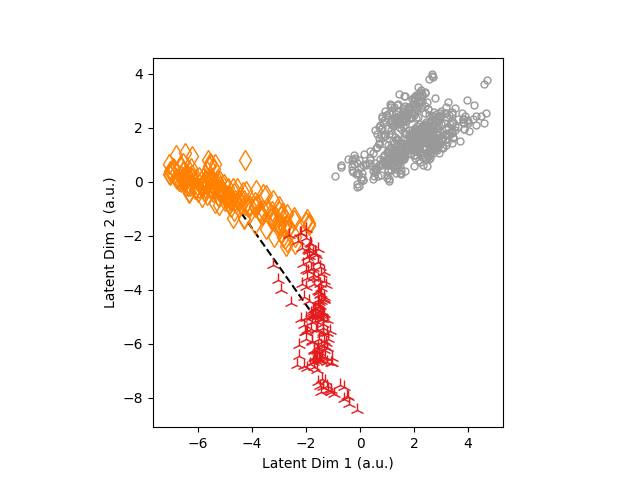

In [79]:
plot_dict = {s_n: {'pts': syn_lda_rs['lda_pts'][s_n]['pts'], 
                   'labels': syn_lda_rs['lda_pts'][s_n]['labels'], 
                   'plot_vec_pts': None} for s_n in subjects}

plot_dict[ex_vis_s_n]['plot_vec_pts'] = syn_lda_rs['disc_vec_pts']


plot_latents(subj_data=plot_dict, 
             label_map=diff_cond_label_map, 
             sp_clrs=subperiod_clrs, 
             subj_markers=subject_markers, 
             subj_specific_axes=False)

plt.savefig(Path(ps['save_folder']) / ('syn_lda_latents.eps'), format='eps')

## View low-d projection of data when we observe different conditions in each subject, fit standard FA models individually, and attempt to put everything into the same space via orthonormalization

In [36]:
orth_ex_vis_s_lm = diff_cond_latents[ex_vis_s_n]['lm_o']

In [37]:
orth_lda_rs = get_lda_projs(latents={s_n: diff_cond_latents[s_n]['latents'] for s_n in subjects},
                            labels={s_n: full_diff_cond_labels[s_n] for s_n in subjects},
                            c0=cmp_conds[0], c1=cmp_conds[1], 
                            label_map=diff_cond_label_map, 
                            ex_lm=orth_ex_vis_s_lm, 
                            tgt_pts=all_cond_lda_rs[ex_vis_s_n]['lda_pts'][ex_vis_s_n]['pts'] , 
                            tgt_labels=all_cond_data['fit_labels'][ex_vis_s_n])

<IPython.core.display.Javascript object>


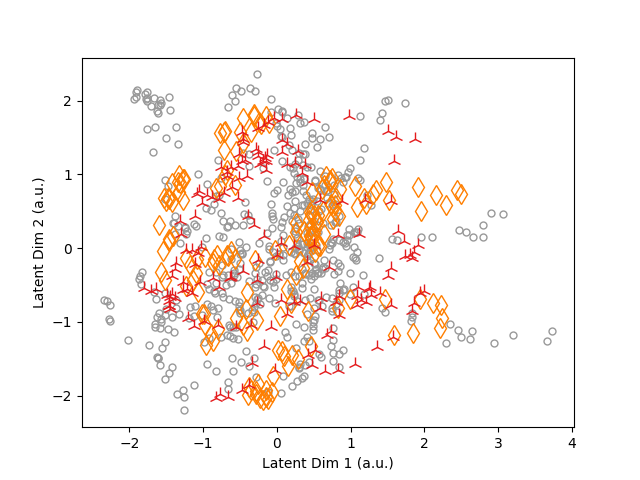

In [80]:
plot_dict = {s_n: {'pts': orth_lda_rs['lda_pts'][s_n]['pts'], 
                   'labels': orth_lda_rs['lda_pts'][s_n]['labels'], 
                   'plot_vec_pts': None} for s_n in subjects}

plot_dict[ex_vis_s_n]['plot_vec_pts'] = orth_lda_rs['disc_vec_pts']


plot_latents(subj_data=plot_dict, 
             label_map=diff_cond_label_map, 
             sp_clrs=subperiod_clrs, 
             subj_markers=subject_markers, 
             subj_specific_axes=False)

plt.savefig(Path(ps['save_folder']) / ('orth_lda_latents.eps'), format='eps')

## View low-d projection of data when we observe different conditions in each subjects, fit standard FA models individually, and attempt to put everything into the same space via optimal transport

In [39]:
ot_ex_vis_s_lm = diff_cond_latents[ex_vis_s_n]['lm']

In [40]:
ot_lda_rs = get_lda_projs(latents={s_n: diff_cond_latents[s_n]['latents_ot'] for s_n in subjects},
                          labels={s_n: full_diff_cond_labels[s_n] for s_n in subjects},
                          c0=cmp_conds[0], c1=cmp_conds[1], 
                          label_map=diff_cond_label_map, 
                          ex_lm=ot_ex_vis_s_lm, 
                          tgt_pts=all_cond_lda_rs[ex_vis_s_n]['lda_pts'][ex_vis_s_n]['pts'] , 
                          tgt_labels=all_cond_data['fit_labels'][ex_vis_s_n])

<IPython.core.display.Javascript object>


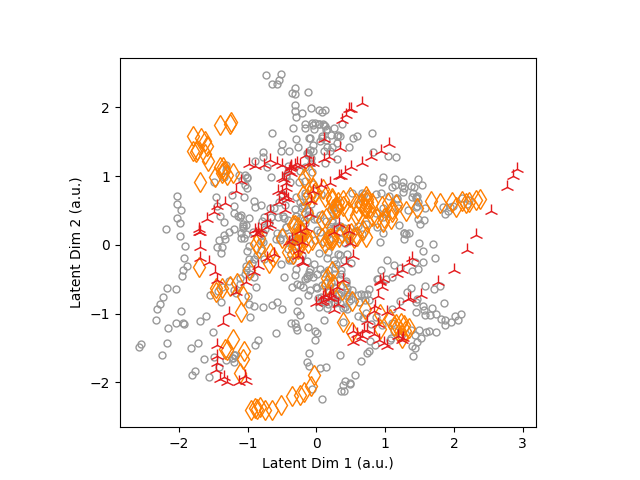

In [81]:
plot_dict = {s_n: {'pts': ot_lda_rs['lda_pts'][s_n]['pts'], 
                   'labels': ot_lda_rs['lda_pts'][s_n]['labels'], 
                   'plot_vec_pts': None} for s_n in subjects}

plot_dict[ex_vis_s_n]['plot_vec_pts'] = ot_lda_rs['disc_vec_pts']


plot_latents(subj_data=plot_dict, 
             label_map=diff_cond_label_map, 
             sp_clrs=subperiod_clrs, 
             subj_markers=subject_markers, 
             subj_specific_axes=False)

plt.savefig(Path(ps['save_folder']) / ('ot_lda_latents.eps'), format='eps')

## Load and prepare the image of the raw volume

In [42]:
ref_brain = scipy.io.loadmat(ps['anat_file'])
ref_brain = ref_brain['anat_stack_norm']
ref_brain = ref_brain/np.max(ref_brain)

In [43]:
rb_horz = signed_max_proj(ref_brain,2)
rb_sag = signed_max_proj(ref_brain,1)
rb_cor = np.fliplr(signed_max_proj(ref_brain,0))

## Generate images showing high-d direction between two conditions from standard FA model fit to one subject with all conditions

In [83]:
plt.style.use("dark_background")

In [45]:
cool_color = [75.0/255, 0.0, 146.0/255.0]
hot_color = [26.0/255, 1.0, 26.0/255.0]

mode_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(name='purple_to_green',
                                                               colors=[(0,  [*cool_color, 1.0]),
                                                                       (.45,  [*cool_color, 0.15]),
                                                                       (.5, [0.0, 0.0, 0.0, 0.0]),
                                                                       (.55, [*hot_color, 0.15]),
                                                                       (1.0, [*hot_color, 1.0])],
                                                                N=1000)

<IPython.core.display.Javascript object>


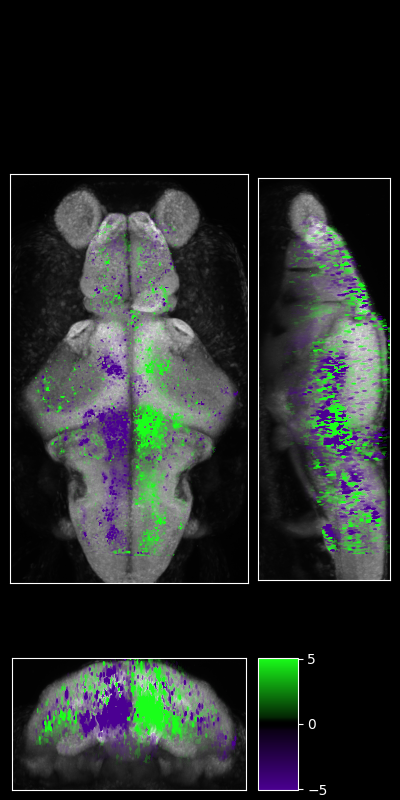

<IPython.core.display.Javascript object>


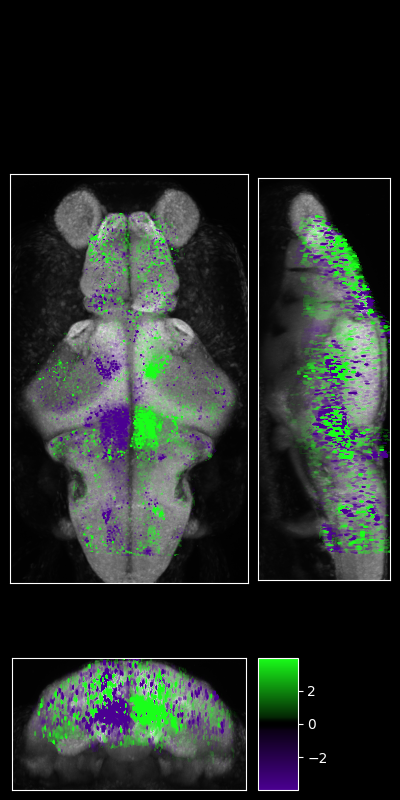

/tmp/ipykernel_380346/2674868165.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize=[4,8])


<IPython.core.display.Javascript object>


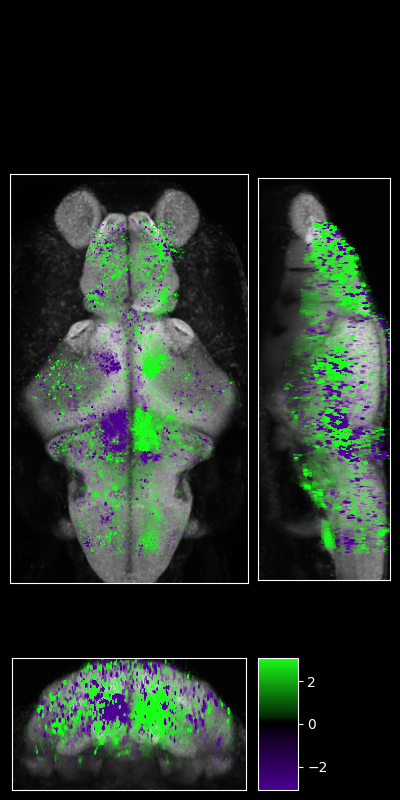

In [84]:
for s_n in subjects:
    dot_ctrs = copy.deepcopy(neuron_locs[s_n].numpy())
    dot_ctrs[:,2] = dot_ctrs[:,2]/2.5
    
    all_cond_mn_diff_3d = generate_dot_image_3d(image_shape=[1050, 610, 138], 
                                            dot_ctrs=dot_ctrs,
                                            dot_vls=all_cond_lda_rs[s_n]['disc_vec_high_d'],
                                            ellipse_shape=[5,5,5])
    
    all_cond_clim = np.percentile(np.abs(all_cond_lda_rs[s_n]['disc_vec_high_d']), ps['mode_c_lim_percentile'])
    vis_mode(rb_horz, rb_sag, rb_cor, all_cond_mn_diff_3d, mode_cmap, [-all_cond_clim, all_cond_clim])
    plt.savefig(Path(ps['save_folder']) / ('standard_fa_all_conds_diff_dir_subj_' + str(s_n) + '.jpg'), format='jpg')

## Generate image showing high-d direction between conditions from synthesized FA models

In [47]:
dot_ctrs = copy.deepcopy(neuron_locs[ex_vis_s_n].numpy())
dot_ctrs[:,2] = dot_ctrs[:,2]/2.5

In [48]:
syn_cond_mn_diff_3d = generate_dot_image_3d(image_shape=[1050, 610, 138], 
                                            dot_ctrs=dot_ctrs,
                                            dot_vls=syn_lda_rs['disc_vec_high_d'], 
                                            ellipse_shape=[5,5,5])

<IPython.core.display.Javascript object>


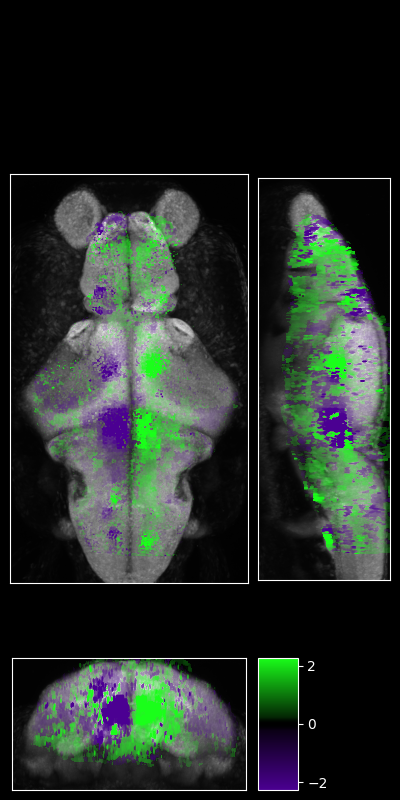

In [85]:
syn_cond_clim = np.percentile(np.abs(syn_lda_rs['disc_vec_high_d']), ps['mode_c_lim_percentile'])
vis_mode(rb_horz, rb_sag, rb_cor, syn_cond_mn_diff_3d, mode_cmap, [-syn_cond_clim, syn_cond_clim])
plt.savefig(Path(ps['save_folder']) / ('syn_diff_dir_subj_' + str(ex_vis_s_n) + '.jpg'), format='jpg')

## Generate image showing high-d direction between conditions when we fit FA models individually and orthonormalize latents

In [50]:
orth_cond_mn_diff_3d = generate_dot_image_3d(image_shape=[1050, 610, 138], 
                                             dot_ctrs=dot_ctrs,
                                             dot_vls=orth_lda_rs['disc_vec_high_d'], 
                                             ellipse_shape=[5,5,5])

<IPython.core.display.Javascript object>


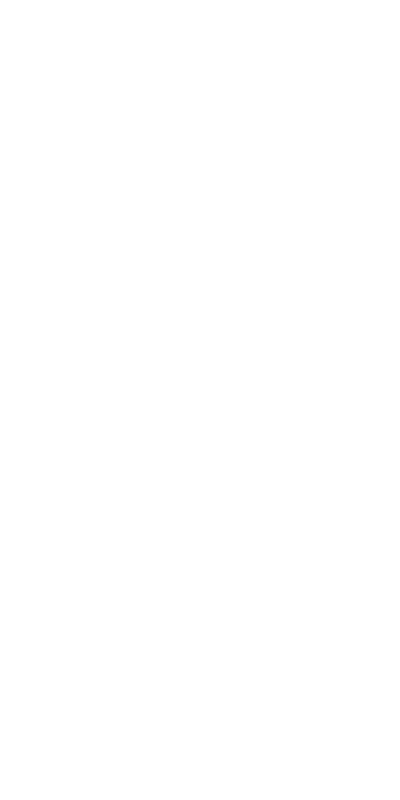

In [51]:
orth_cond_clim = np.percentile(np.abs(orth_lda_rs['disc_vec_high_d']), ps['mode_c_lim_percentile'])
vis_mode(rb_horz, rb_sag, rb_cor, orth_cond_mn_diff_3d, mode_cmap, [-orth_cond_clim, orth_cond_clim])
plt.savefig(Path(ps['save_folder']) / ('orth_diff_dir_subj_' + str(ex_vis_s_n) + '.jpg'), format='jpg')

## Generate image showing high-d direction between conditions when we fit FA models individually and then use distribution alignment to try to put all latents in the same space

In [52]:
ot_cond_mn_diff_3d = generate_dot_image_3d(image_shape=[1050, 610, 138], 
                                           dot_ctrs=dot_ctrs,
                                           dot_vls=ot_lda_rs['disc_vec_high_d'], 
                                           ellipse_shape=[5,5,5])

<IPython.core.display.Javascript object>


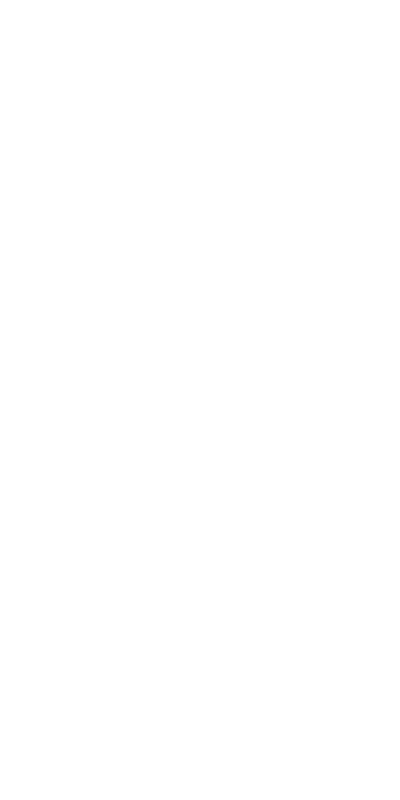

In [53]:
align_cond_clim = np.percentile(np.abs(ot_lda_rs['disc_vec_high_d']), ps['mode_c_lim_percentile'])
vis_mode(rb_horz, rb_sag, rb_cor, ot_cond_mn_diff_3d, mode_cmap, [-align_cond_clim, align_cond_clim])
plt.savefig(Path(ps['save_folder']) / ('ot_diff_dir_subj_' + str(ex_vis_s_n) + '.jpg'), format='jpg')

In [54]:
%matplotlib notebook
plt.style.use("default")

## View top latent dimensions (by variance) when we observe all conditions in all subjects. 

In [55]:
n_plot_var_dims = 3

<IPython.core.display.Javascript object>


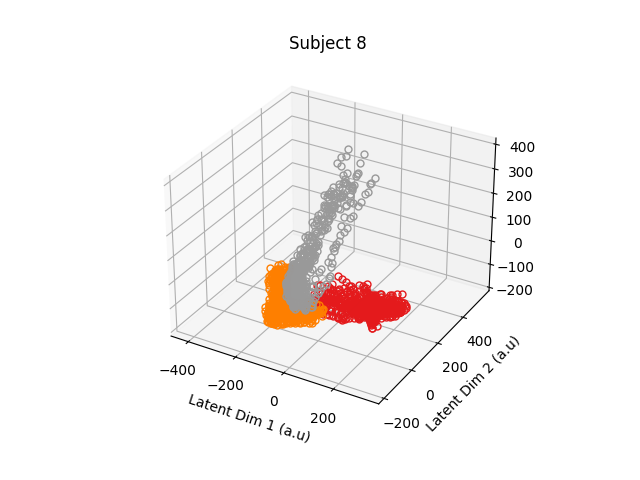

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>


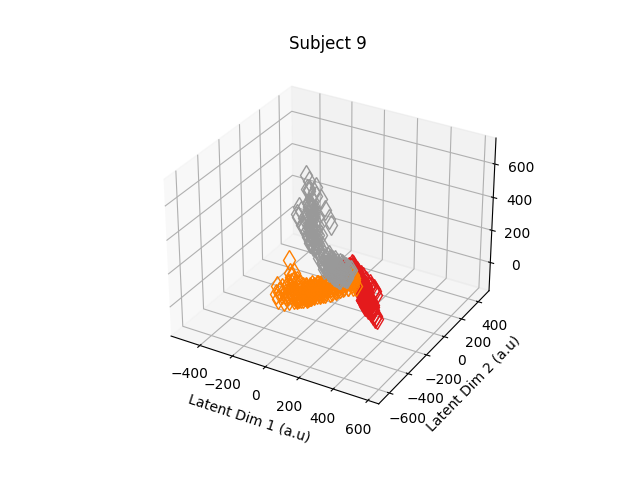

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>


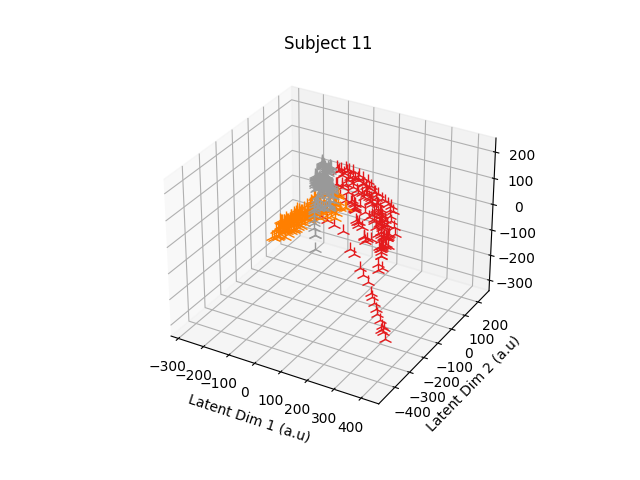

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [56]:
for s_n in subjects:  
    
    if s_n != ex_vis_s_n:
        rot = find_best_rot(all_cond_latents[ex_vis_s_n]['latents_o'][:,0:n_plot_var_dims], 
                            all_cond_data['fit_labels'][ex_vis_s_n], 
                            all_cond_latents[s_n]['latents_o'][:, 0:n_plot_var_dims], 
                            all_cond_data['fit_labels'][s_n])
    else:
        rot = np.eye(n_plot_var_dims)
        

    pts = np.matmul(all_cond_latents[s_n]['latents_o'][:, 0:n_plot_var_dims], rot)
                                                       
    plot_dict = {'pts': pts,
                 'labels': all_cond_lda_rs[s_n]['lda_pts'][s_n]['labels'],
                 'plot_vec_pts': None}
    
    plot_latents(subj_data={s_n: plot_dict}, 
                 label_map=all_cond_label_map, 
                 sp_clrs=subperiod_clrs, 
                 subj_markers=subject_markers, 
                 x_label='Latent Dim 1 (a.u)', y_label='Latent Dim 2 (a.u)', z_label='Latebt Dim 3 (a.u.)')
    plt.savefig(Path(ps['save_folder']) / ('standard_fa_all_conds_top_latents_subj' + str(s_n) + '.eps'), format='eps')

## View top latent dimensions (by variance) when we observe different conditions in each subject and synthesize models

In [57]:
syn_rot = find_best_rot(all_cond_latents[ex_vis_s_n]['latents_o'][:,0:n_plot_var_dims], 
                    all_cond_data['fit_labels'][ex_vis_s_n], 
                    np.concatenate([syn_latents[s_n]['latents_o'] for s_n in subjects], axis=0)[:, 0:n_plot_var_dims], 
                    np.concatenate([full_diff_cond_labels[s_n] for s_n in subjects], axis=0))

In [58]:
syn_top_var_plot_dicts = {}
for s_n in subjects:
    syn_top_var_plot_dicts[s_n] = {'pts': np.matmul(syn_latents[s_n]['latents_o'][:, 0:n_plot_var_dims], syn_rot),
                                   'labels': full_diff_cond_labels[s_n],
                                   'plot_vec_pts': None}

<IPython.core.display.Javascript object>


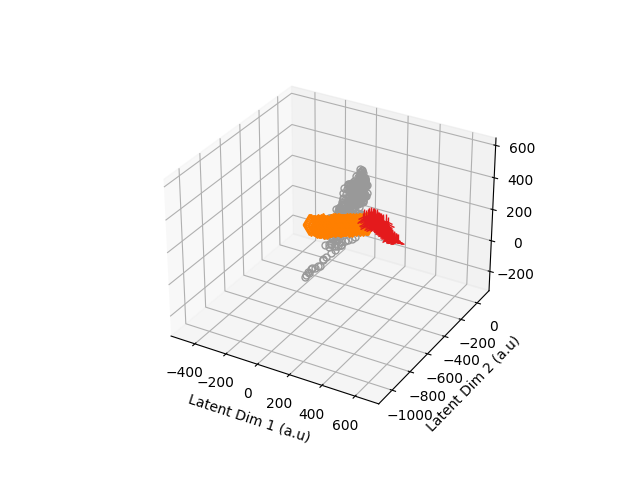

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [59]:
plot_latents(subj_data=syn_top_var_plot_dicts, 
             label_map=diff_cond_label_map, 
             sp_clrs=subperiod_clrs, 
             subj_markers=subject_markers, 
             x_label='Latent Dim 1 (a.u)', y_label='Latent Dim 2 (a.u)', z_label='Latebt Dim 3 (a.u.)', 
             subj_specific_axes=False)

plt.savefig(Path(ps['save_folder']) / ('syn_top_latents.eps'), format='eps')

## View top latent dimensions (by variance) when we observe different conditions in each subject, fit standard FA models individually, and attempt to put everything into the same space via orthonormalization

In [60]:
orth_rot = find_best_rot(all_cond_latents[ex_vis_s_n]['latents_o'][:,0:n_plot_var_dims], 
                    all_cond_data['fit_labels'][ex_vis_s_n], 
                    np.concatenate([diff_cond_latents[s_n]['latents_o'] for s_n in subjects], axis=0)[:, 0:n_plot_var_dims], 
                    np.concatenate([full_diff_cond_labels[s_n] for s_n in subjects], axis=0))

In [61]:
orth_top_var_plot_dicts = {}
for s_n in subjects:
    orth_top_var_plot_dicts[s_n] = {'pts': np.matmul(diff_cond_latents[s_n]['latents_o'][:, 0:n_plot_var_dims], 
                                                     orth_rot),
                                   'labels': full_diff_cond_labels[s_n],
                                   'plot_vec_pts': None}

<IPython.core.display.Javascript object>


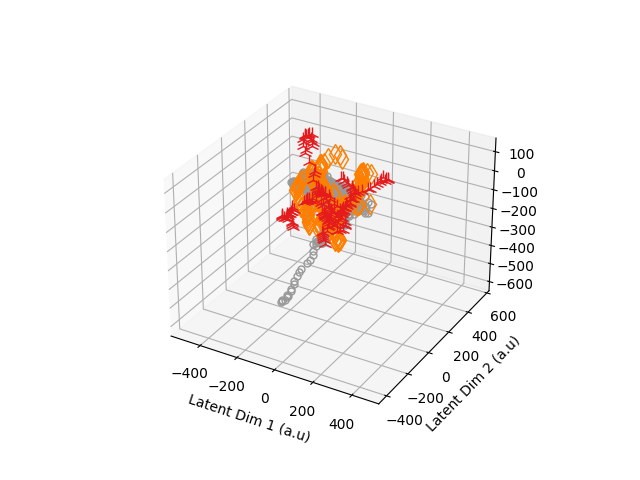

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [62]:
plot_latents(subj_data=orth_top_var_plot_dicts, 
             label_map=diff_cond_label_map, 
             sp_clrs=subperiod_clrs, 
             subj_markers=subject_markers, 
             x_label='Latent Dim 1 (a.u)', y_label='Latent Dim 2 (a.u)', z_label='Latebt Dim 3 (a.u.)', 
             subj_specific_axes=False)

plt.savefig(Path(ps['save_folder']) / ('orth_top_latents.eps'), format='eps')

## View top latent dimensions (by variance) when we observe different conditions in each subject, fit standard FA models individually, and attempt to put everything into the same space via optimal transport

In [63]:
ot_rot = find_best_rot(all_cond_latents[ex_vis_s_n]['latents_o'][:,0:n_plot_var_dims], 
                       all_cond_data['fit_labels'][ex_vis_s_n], 
                       np.concatenate([diff_cond_latents[s_n]['latents_ot'] for s_n in subjects], axis=0)[:, 0:n_plot_var_dims], 
                       np.concatenate([full_diff_cond_labels[s_n] for s_n in subjects], axis=0))

In [64]:
ot_top_var_plot_dicts = {}
for s_n in subjects:
    ot_top_var_plot_dicts[s_n] = {'pts': np.matmul(diff_cond_latents[s_n]['latents_ot'][:, 0:n_plot_var_dims], 
                                                     ot_rot),
                                   'labels': full_diff_cond_labels[s_n],
                                   'plot_vec_pts': None}

<IPython.core.display.Javascript object>


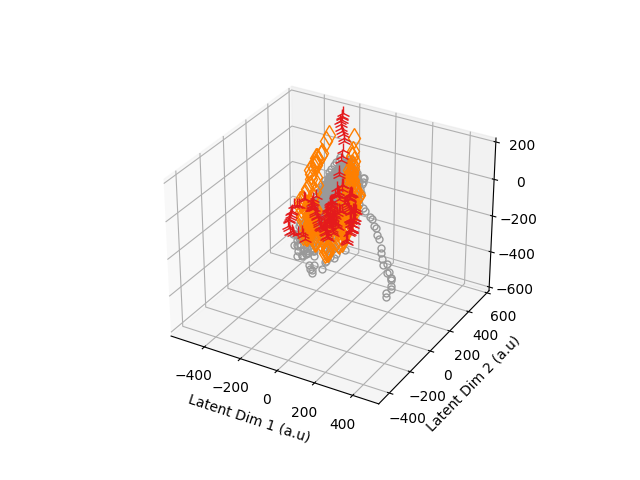

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [65]:
plot_latents(subj_data=ot_top_var_plot_dicts, 
             label_map=diff_cond_label_map, 
             sp_clrs=subperiod_clrs, 
             subj_markers=subject_markers, 
             x_label='Latent Dim 1 (a.u)', y_label='Latent Dim 2 (a.u)', z_label='Latebt Dim 3 (a.u.)', 
             subj_specific_axes=False)

plt.savefig(Path(ps['save_folder']) / ('ot_top_latents.eps'), format='eps')

## Now visualize the modes explaining the $n^\text{th}$ most variance when we fit standard models individually to subjects under different conditions

In [66]:
plt.style.use("dark_background")

In [67]:
modes_to_make_imgs_for = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # Orthonormalized modes we want images for

In [68]:
diff_cond_mode_imgs = dict()
for s_n in subjects:
    mode_imgs_n = dict()
    for m_i in modes_to_make_imgs_for:
        dot_ctrs = copy.deepcopy(neuron_locs[s_n].numpy())
        dot_ctrs[:,2] = dot_ctrs[:,2]/2.5
        mode_imgs_n[m_i] = {'img': generate_dot_image_3d(image_shape=[1050, 610, 138],
                                                 dot_ctrs=dot_ctrs,
                                                 dot_vls=diff_cond_latents[s_n]['lm_o'][:, m_i],
                                                 ellipse_shape=[5,5,5]),
                            'clim': np.percentile(np.abs(diff_cond_latents[s_n]['lm_o'][:, m_i]), 
                                                  ps['mode_c_lim_percentile'])}
        
    diff_cond_mode_imgs[s_n] = mode_imgs_n
    print('Done making mode images for subject ' + str(s_n) + '.')


Done making mode images for subject 8.
Done making mode images for subject 9.
Done making mode images for subject 11.


In [69]:
vis_mode_i = 0

<IPython.core.display.Javascript object>


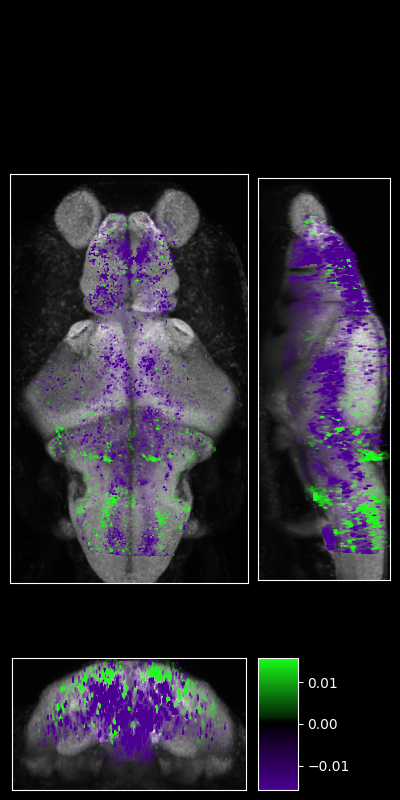

<IPython.core.display.Javascript object>


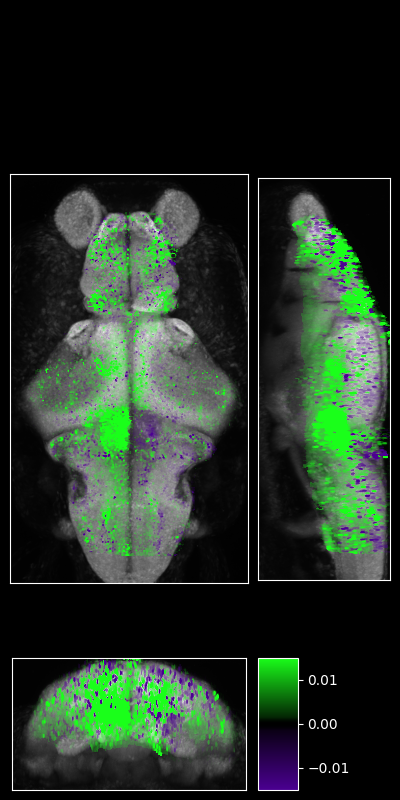

<IPython.core.display.Javascript object>


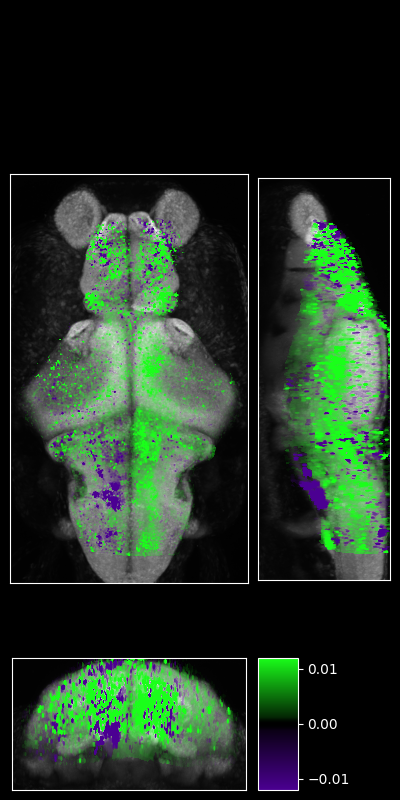

In [70]:
for s_n in subjects:
    vol = diff_cond_mode_imgs[s_n][vis_mode_i]['img']
    cur_clim = diff_cond_mode_imgs[s_n][vis_mode_i]['clim']
    vis_mode(rb_horz, rb_sag, rb_cor, vol, mode_cmap, [-cur_clim, cur_clim])
    plt.savefig(Path(ps['save_folder']) / ('standard_fa_ind_cond_mode_' + str(vis_mode_i) + '_subj_' + str(s_n) + '.jpg'), format='jpg')
  

## Now visualize the mode explaining the most variance in the latent space for the synthesized models

Note that this is slightly different than orthonormalization

In [71]:
with torch.no_grad():
    syn_lm_o = joint_orth([eval_posteriors[s_i].lm_post(neuron_locs[s_n]).numpy() for s_i, s_n in enumerate(subjects)])

Percent variance explained by each latent dimension: [50.86709   17.37321    9.487897   7.0917554  4.398182   2.794805
  2.586612   2.1238153  1.676672   1.5999588]


In [72]:
#with torch.no_grad():
#    syn_lm_o = [(orthonormalize(eval_posteriors[s_i].lm_post(neuron_locs[s_n]).numpy())[0]) 
#            for s_i, s_n in enumerate(subjects)]

In [73]:
syn_mode_imgs = dict()
for s_i, s_n in enumerate(subjects):
    dot_ctrs = copy.deepcopy(neuron_locs[s_n].numpy())
    dot_ctrs[:,2] = dot_ctrs[:,2]/2.5
    
    mode_imgs_n = dict()
    for m_i in modes_to_make_imgs_for:
    
        mode_imgs_n[m_i] = {'img': generate_dot_image_3d(image_shape=[1050, 610, 138],
                                                         dot_ctrs=dot_ctrs,
                                                         dot_vls=syn_lm_o[s_i][:,m_i],
                                                         ellipse_shape=[5,5,5]),
                            'clim': np.percentile(np.abs(syn_lm_o[s_i][:,m_i]), ps['mode_c_lim_percentile'])}
        
    syn_mode_imgs[s_n] = mode_imgs_n
    print('Done making mode images for subject ' + str(s_n) + '.')


Done making mode images for subject 8.
Done making mode images for subject 9.
Done making mode images for subject 11.


In [74]:
vis_mode_i = 8

<IPython.core.display.Javascript object>


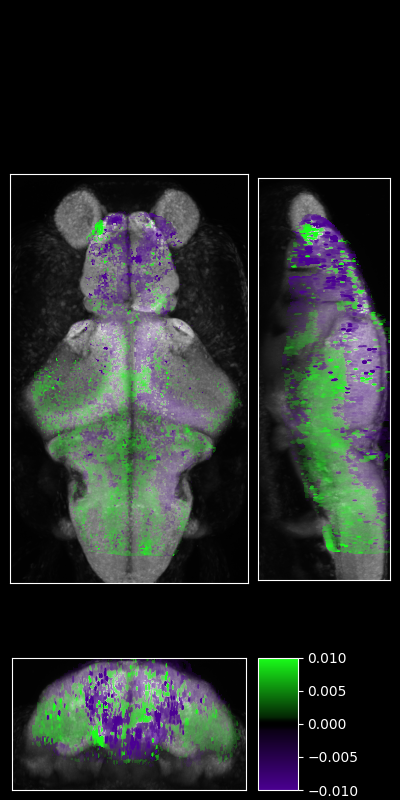

<IPython.core.display.Javascript object>


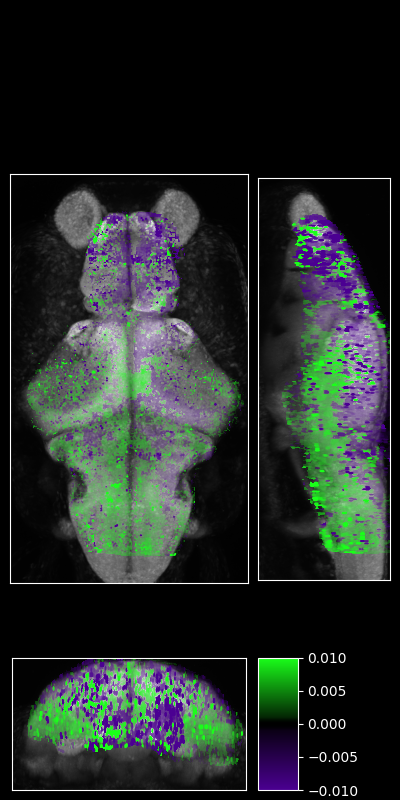

<IPython.core.display.Javascript object>


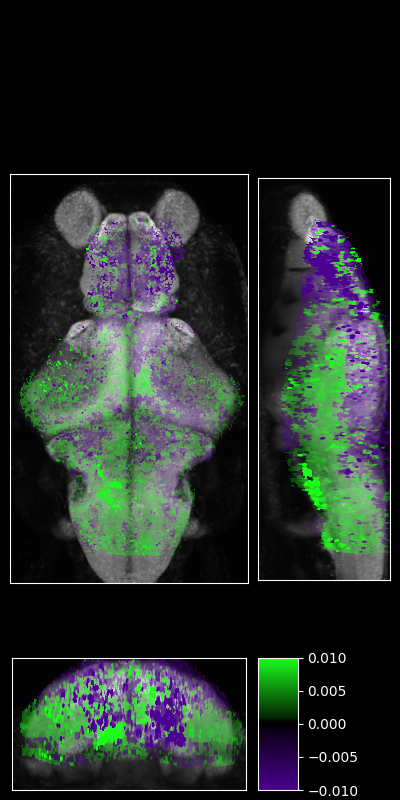

In [75]:
for s_n in subjects:
    vol = syn_mode_imgs[s_n][vis_mode_i]['img']
    cur_clim = .01 #syn_mode_imgs[s_n][vis_mode_i]['clim']
    vis_mode(rb_horz, rb_sag, rb_cor, vol, mode_cmap, [-cur_clim, cur_clim])
    plt.savefig(Path(ps['save_folder']) / ('syn_mode_' + str(vis_mode_i) + '_subj_' + str(s_n) + '.jpg'), format='jpg')